In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [243]:
data = pd.read_parquet('modeling_notebooks/data/rel_tweets_with_sentiment.gzip')
data.head()

,grid_id,tweet_id_x,created_at,text,author_id,place_id,lat,long,full_name,name,...,id,county,tweet_id_y,tag,relevance_pred,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class
0,40,820841383099437058,2017-01-16 03:53:30,Back of the camera preview from today at the r...,231610931,fbd6d2f5a4e4a15e,-121.697000,41.948800,"California, USA",California,...,40,SISKIYOU,8.208414e+17,1.0,1.0,0.094,0.906,0.000,-0.2411,negative
2,73,19057484971,2010-07-21 06:52:06,And now I hear coyotes... they better not hurt...,54453264,ca06c9bd1e591f53,NaN,NaN,"Butte Valley, CA",Butte Valley,...,73,SISKIYOU,1.905748e+10,1.0,1.0,0.000,0.579,0.421,0.7616,positive
3,101,364985527600033795,2013-08-07 05:45:05,Goal for tomorrow is to rope a coyote #gottah...,266238333,e057ac551ce5df02,-122.611145,41.742534,"Yreka, CA",Yreka,...,101,SISKIYOU,3.649855e+17,1.0,0.0,0.000,1.000,0.000,0.0000,neutral
4,101,1397357765811597312,2021-05-26 01:03:47,@numinousstock I could potentially run into a ...,2802522932,e057ac551ce5df02,NaN,NaN,"Yreka, CA",Yreka,...,101,SISKIYOU,1.397358e+18,1.0,1.0,0.000,1.000,0.000,0.0000,neutral
5,171,1037004682906857472,2018-09-04 15:49:17,@nazani14 @Dedpull_Diva We have coyotes here a...,781022262812114944,07d9f503d8884001,NaN,NaN,Lake Shastina Golf Course,Lake Shastina Golf Course,...,171,SISKIYOU,1.037005e+18,1.0,1.0,0.000,0.955,0.045,0.2732,positive


# Sentiment Analysis

## Check average and variance of compound sentiment score

In [244]:
sent_avg = data['compound_sent_score'].mean()
sent_var = data['compound_sent_score'].std()
print(f'Average Compound Sentiment Score: {sent_avg:.3f}')
print(f'Compound Sentiment Score Standard Deviation: {sent_var:.3f}')
print(f'Number of observations: {data.shape[0]}')

Average Compound Sentiment Score: 0.004
Compound Sentiment Score Standard Deviation: 0.449
Number of observations: 14202


The average compound score indicates that on average, there is a neutral sentiment towards human-coyote interactions. However, the standard deviation is relatively high indicating that the compound score can vary between positive and negative with one standard deviation up or down respectively.

## Let look at a histogram of the compound sentiment score and classification

In [245]:
class_counts = data.groupby('sent_class')['text'].count().sort_values(ascending=False)
class_counts

sent_class
positive    4777
neutral     4744
negative    4681
Name: text, dtype: int64

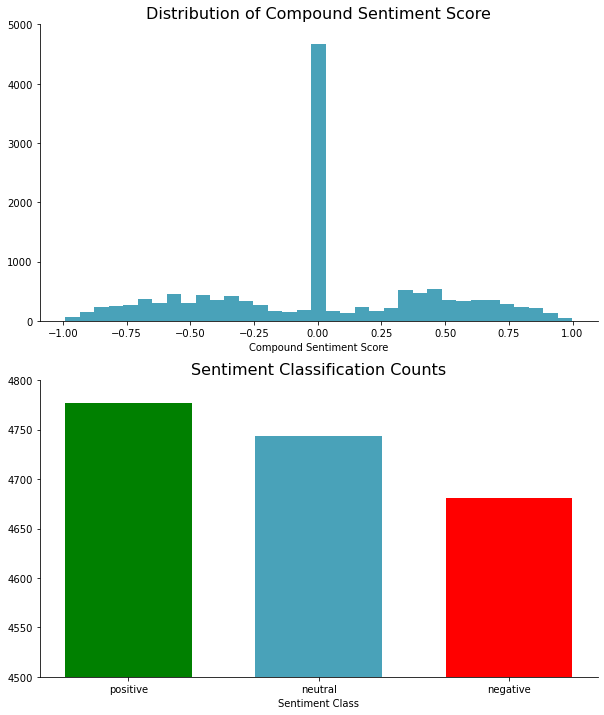

In [257]:
fig, ax = plt.subplots(figsize=(10, 12), nrows=2)
# Score histogram
ax[0].hist(data['compound_sent_score'], bins=35, color='#49a2b9')
ax[0].set_title('Distribution of Compound Sentiment Score', size=16)
ax[0].set_xlabel('Compound Sentiment Score')
ax[0].set_ylim(0, 5000)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# Class bar
ax[1].bar(
    class_counts.index,
    class_counts,
    width=2/3,
    color=['green', '#49a2b9','red']
)
ax[1].set_title('Sentiment Classification Counts', size=16)
ax[1].set_xlabel('Sentiment Class')
ax[1].set_ylim(4500, 4800)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig('plots/sentiment_dis.png', transparent=False)
plt.show()

## Timeseries of compound score

In [349]:
# Look at min and max dates
data['created_at'].min(), data['created_at'].max()

(Timestamp('2010-03-23 18:48:21'), Timestamp('2022-03-01 04:49:47'))

In [350]:
# Get month-year
data['month_year'] = data['created_at'].dt.to_period('M').astype('string')

In [351]:
# Group by the month_year
sent_by_date = data.groupby('month_year', sort=True)['compound_sent_score'].mean()

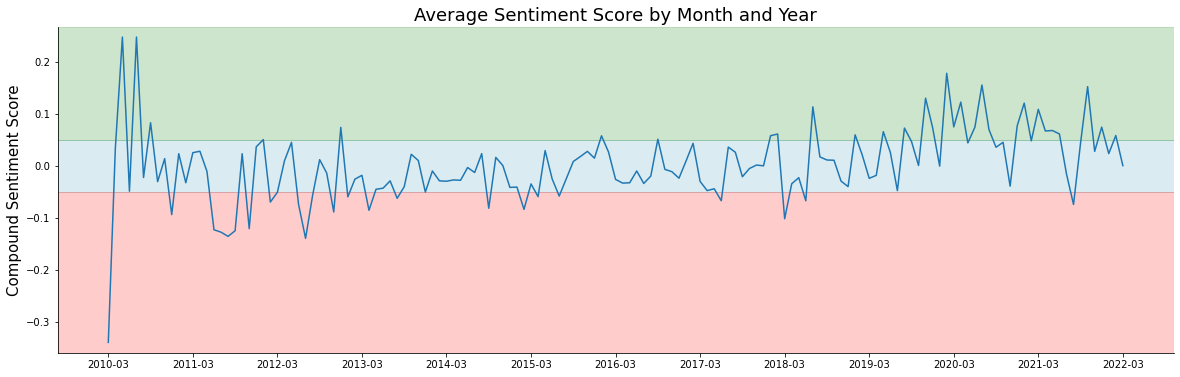

In [354]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(
    sent_by_date.index.values,
    sent_by_date.values
)
ax.set_xticks([sent_by_date.index.values[i] for i in range(0, len(sent_by_date), 12)])
ax.set_ylabel('Compound Sentiment Score', size=15)
ax.set_title('Average Sentiment Score by Month and Year', size=18)
ax.axhspan(-0.05, 0.05, alpha=.2, color='#49a2b9')
ax.axhspan(0.05, max(sent_by_date.values)+0.02, alpha=.2, color='green')
ax.axhspan(min(sent_by_date.values)-0.02, -0.05, alpha=.2, color='red')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(min(sent_by_date.values)-0.02, max(sent_by_date.values)+0.02)

plt.savefig('plots/sentiment_TS.png')
plt.show()

# Group data by county

In [356]:
county_group = data.groupby('county')['compound_sent_score'].mean().sort_values(ascending=False)
county_group

county
COLUSA             0.764200
MENDOCINO          0.489980
TEHAMA             0.191776
AMADOR             0.185000
CALAVERAS          0.174333
LAKE               0.159100
SHASTA             0.149295
MONO               0.142748
NAPA               0.141381
TUOLUMNE           0.134233
SISKIYOU           0.132283
SACRAMENTO         0.109684
KINGS              0.097454
SAN LUIS OBISPO    0.084406
HUMBOLDT           0.084283
MARIN              0.084110
MONTEREY           0.082979
CONTRA COSTA       0.082786
NEVADA             0.073971
EL DORADO          0.067890
SONOMA             0.067654
ALAMEDA            0.064111
SAN FRANCISCO      0.059460
SOLANO             0.055450
LASSEN             0.051600
VENTURA            0.049687
SANTA CLARA        0.048965
MARIPOSA           0.045954
PLACER             0.044237
SAN MATEO          0.044232
KERN               0.043105
MADERA             0.039647
IMPERIAL           0.035900
STANISLAUS         0.031465
YOLO               0.023922
BUTTE        

/var/folders/50/cgfcx8d97_52qyt5jj7jf52w0000gn/T/ipykernel_13933/3635848619.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(county_group.index.values, size=9)


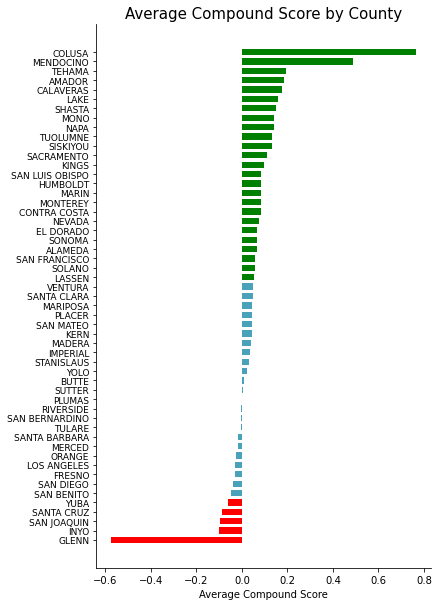

In [384]:
fig, ax = plt.subplots(figsize=(6, 10))
colors = []
for v in county_group.values:
    if v > 0.05:
        colors.append('green')
    elif v < -0.05:
        colors.append('red')
    else:
        colors.append('#49a2b9')


ax.barh(
    county_group.index.values,
    county_group.values,
    height=2/3,
    color=colors
)
ax.set_title('Average Compound Score by County', size=15)
ax.set_xlabel('Average Compound Score')
ax.set_yticklabels(county_group.index.values, size=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gca().invert_yaxis()
plt.savefig('plots/sent_by_county.png')
plt.show()